In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import numpy as np
import pandas as pd
from matplotlib import rcParams
from metpy.plots import Hodograph, SkewT
from metpy.units import units
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from siphon.simplewebservice.wyoming import WyomingUpperAir

In [2]:
label_sizes = {"xtick.labelsize": 12, "ytick.labelsize": 12, "axes.labelsize": 14}

rcParams.update(label_sizes)

In [3]:
time = datetime(2011, 5, 22, 12)
station = "TOP"
df = WyomingUpperAir.request_data(time, station)

In [4]:
df = df.dropna(
    subset=("temperature", "dewpoint", "direction", "speed"), how="all"
).reset_index(drop=True)

df = df.drop(df.index[np.append(np.diff(df["pressure"]) >= 0, False)])

In [5]:
p = df["pressure"].values * units.hPa
T = df["temperature"].values * units.degC
Td = df["dewpoint"].values * units.degC
wind_speed = df["speed"].values * units.knots
wind_dir = df["direction"].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)
hght = df["height"].values * units.meter

In [6]:
below_100_hpa = p >= 101.0 * units.hPa

In [10]:
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to("degC")
li = mpcalc.lifted_index(p, T, prof)[0]
cape, cin = mpcalc.cape_cin(p, T, Td, prof)
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
lfc_pressure, lfc_temperature = mpcalc.lfc(p, T, Td, prof)
el_pressure, el_temperature = mpcalc.el(p, T, Td, prof)

indices = f"""CAPE = {cape:.0f~P}
CIN = {cin:.0f~P}
LI = {li.m:.0f}
LCL = {lcl_pressure:.0f~P}
LFC = {lfc_pressure:.0f~P}
EL = {el_pressure:.0f~P}"""

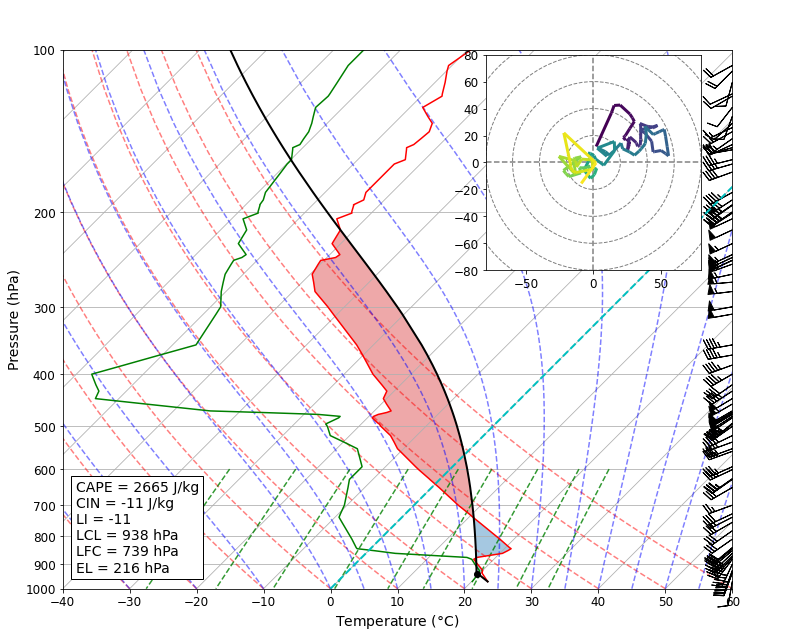

In [11]:
fig = plt.figure(figsize=(12, 12))
# add_metpy_logo(fig, 60, 50)
skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot.
skew.plot(p, T, "r")
skew.plot(p, Td, "g")
skew.plot_barbs(p[below_100_hpa], u[below_100_hpa], v[below_100_hpa])
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Calculate LCL height and plot as black dot. Because `p`'s first value is
# ~1000 mb and its last value is ~250 mb, the `0` index is selected for
# `p`, `T`, and `Td` to lift the parcel from the surface. If `p` was inverted,
# i.e. start from low value, 250 mb, to a high value, 1000 mb, the `-1` index
# should be selected.
skew.plot(lcl_pressure, lcl_temperature, "ko", markerfacecolor="black")

# Calculate full parcel profile and add to plot as black line
skew.plot(p, prof, "k", linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, prof, Td)
skew.shade_cape(p, T, prof)

# An example of a slanted line at constant T -- in this case the 0
# isotherm
skew.ax.axvline(0, color="c", linestyle="--", linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

fig.text(
    0.14, 0.21, indices, size=14, ha="left", bbox=dict(boxstyle="square", fc="white")
)

skew.ax.set_ylabel(f"Pressure ({p.units:~P})")
skew.ax.set_xlabel(fr"Temperature (${T.units:~L}$)")
# skew.ax.set_title("KTOP 2011-05-22 1200 UTC")

ax_hodo = inset_axes(skew.ax, "40%", "40%", loc=1)
hodo = Hodograph(ax_hodo, component_range=80.0)
hodo.add_grid(increment=20)
hodo.plot_colormapped(u, v, hght)

# restplt.savefig("metpy_bams_skewt.png")

#### draft caption
Vertical profile of the atmosphere, valid from Topeka (TOP) May 22 2011 1200 UTC, presented on a Skew-T log-p diagram. Shown are observed temperature (red line), dewpoint temperature (green line), calculated parcel profile trace (black line), and 0-degree isotherm (blue line, dashed), and wind barbs (knots, right axis), with shaded areas for CIN (blue shaded) and CAPE (red shaded.) MetPy-calculated indices are inset in the lower-left, and a hodograph presented in the upper-right.